In [ ]:
!pip install pickle5
!pip install umap-learn
!pip install yellowbrick

#topic modeling with BERT



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/cop')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
import re
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import string 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import umap.umap_ as umap
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [ ]:
with open("low_cls_embeddings.pickle","rb") as fr:
    low_embedding = pickle.load(fr)

with open("high_cls_embeddings.pickle","rb") as fr:
    up_embeddings = pickle.load(fr)

In [ ]:
low_umap= umap.UMAP(n_neighbors=50, 
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(low_embeddings)

up_umap = umap.UMAP(n_neighbors=50, 
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(up_embeddings)

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


def predict_topics_with_kmeans(embeddings,num_topics):
  kmeans_model =  KMeans(n_clusters= num_topics, init='k-means++', n_init=10, max_iter=100, random_state=42)
  kmeans_model.fit(embeddings)
  topics_labels = kmeans_model.predict(embeddings)
  return topics_labels

    
def plot_embeddings(embedding, labels,title):
    labels = np.array( labels )
    distinct_labels =  set( labels )
    
    n = len(embedding)
    counter = Counter(labels)
    for i in range(len( distinct_labels )):
        ratio = (counter[i] / n )* 100
        cluster_label = f"cluster {i}: { round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.legend(title="Topic",loc = 'upper left', bbox_to_anchor=(1.01,1))
    plt.title(title)
    

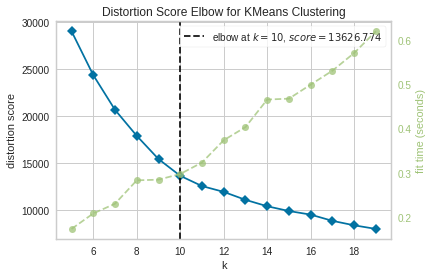

In [ ]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(5,20))
 
visualizer.fit(low_umap)       
visualizer.show()        # Finalize and render the figure

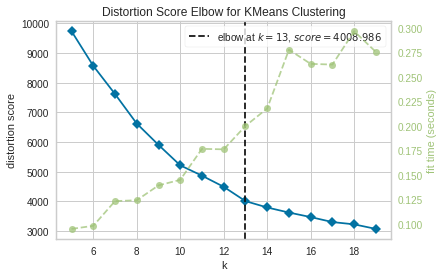

In [ ]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(5,20))
 
visualizer.fit(up_umap)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

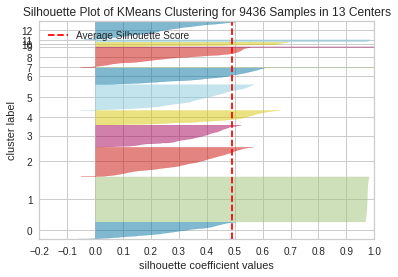

In [ ]:
km = KMeans(n_clusters=13, init='k-means++', n_init=10, max_iter=100, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(up_umap)        # Fit the data to the visualizer
visualizer.show() 

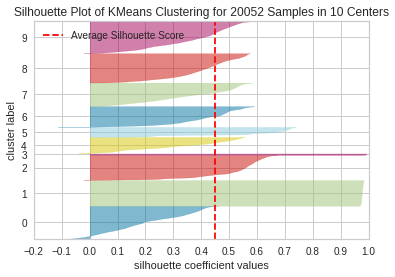

In [ ]:
km = KMeans(n_clusters=10, init='k-means++', n_init=10, max_iter=100, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(low_umap)        # Fit the data to the visualizer
visualizer.show() 

In [ ]:
#upper_umap_bert = reduce_umap( upperclass )
#lower_umap_bert = reduce_umap( lowerclass )
upper_bert_label  = predict_topics_with_kmeans(up_umap, 13)
lower_bert_label  = predict_topics_with_kmeans(low_umap, 10)

In [ ]:
corpus = [' '.join(line) for line in lower['tokenized']] 
lowdocs = pd.DataFrame(corpus)
lowdocs.columns = ['Doc']
lowdocs['Topic'] = lower_bert_label
lowdocs['Doc_ID'] = range(len(lowdocs))
lowdocs_per_topic = lowdocs.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


corpus = [' '.join(line) for line in upper['tokenized']] 
updocs = pd.DataFrame(corpus)
updocs.columns = ['Doc']
updocs['Topic'] = upper_bert_label
updocs['Doc_ID'] = range(len(updocs))
updocs_per_topic = updocs.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
tf_idf, count = c_tf_idf(lowdocs_per_topic.Doc.values, m=len(lower))
top_n_wordslow = extract_top_n_words_per_topic(tf_idf, count, lowdocs_per_topic, n=50)
topic_sizeslow = extract_topic_sizes(lowdocs); topic_sizeslow.head(10)

tf_idf, count = c_tf_idf(updocs_per_topic.Doc.values, m=len(upper))
top_n_wordsup = extract_top_n_words_per_topic(tf_idf, count, updocs_per_topic, n=50)
topic_sizesup = extract_topic_sizes(updocs); topic_sizesup.head(10)

In [ ]:
cluster = pd.DataFrame(lower_bert_label, columns = ['cluster'])
lower['cluster']=cluster

cluster = pd.DataFrame(upper_bert_label, columns = ['cluster'])
upper['cluster']=cluster


In [ ]:
lowtext=[]
for i in range(0, 13):
  LC = lower.loc[lower['cluster']== i]
  fb = [' '.join(line) for line in LC['tokenized']] 
  lowtext.append(fb)

uptext=[]
for i in range(0, 11):
  LC = upper.loc[upper['cluster']== i]
  fb = [' '.join(line) for line in LC['tokenized']] 
  uptext.append(fb)

In [ ]:
upresult=[]
for i in uptext:
  print(len(i))
  try:
    tfidf = TfidfVectorizer()
    pre_tfidf = tfidf.fit(i)
    pre_tfidf_matrix= tfidf.transform(i).toarray()
    pre_tfidf = tfidf.get_feature_names()
    df_pre_tfidf= pd.DataFrame(pre_tfidf_matrix, columns=pre_tfidf)
    df_pre_tfidf = pd.DataFrame(df_pre_tfidf.sum())
    df_pre_tfidf_top = df_pre_tfidf.sort_values(by=0, ascending=False)
    xb= df_pre_tfidf_top.index.tolist()
    fb=xb[:30]
    upresult.append(fb)
  except:
    continue
    

lowresult=[]
for i in lowtext:
  try:
    tfidf = TfidfVectorizer()
    pre_tfidf = tfidf.fit(i)
    pre_tfidf_matrix= tfidf.transform(i).toarray()
    pre_tfidf = tfidf.get_feature_names()
    df_pre_tfidf= pd.DataFrame(pre_tfidf_matrix, columns=pre_tfidf)
    df_pre_tfidf = pd.DataFrame(df_pre_tfidf.sum())
    df_pre_tfidf_top = df_pre_tfidf.sort_values(by=0, ascending=False)
    xb= df_pre_tfidf_top.index.tolist()
    fb=xb[:30]
    lowresult.append(fb)
  except:
    continue

In [ ]:
uptfidf = pd.DataFrame({'keywords': upresult})
lowtfidf = pd.DataFrame({'keywords': lowresult})
uptfidf.to_csv("./uptfidf.csv")
lowtfidf.to_csv("./lowtfidf.csv")